## Times Series Challenge
An extensive exploratory analysis stands usually at the beginning of each data science project.
In this notebook we focus on missing data in a temperature time series of, to some degree,
non-equidistant datapoints. The dataset - as we will find out below - comes with one two
categorical features, one of which (property_name) contains useful information for the analysis.

Outline of the analysis:<br>
1. Package imports and loading data
2. Quick Insights in the dataset
3. Daily, Hourly Seasonalities and Time Differences
4. Hierarchical Clustering for Segmentation
5. Modeling of Time Series Segments
6. Final Remarks



### 1. Package imports and loading data


In [1]:
import numpy as np
import sweetviz as sv
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster
import plotly.express as px
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose

df=pd.read_csv('../../data/sample_temperature_data_for_coding_challenge.csv')
df.index = pd.to_datetime(df.datetime)
print('Imports done!')

Imports done!


### 2. Quick Insights in the Dataset
Here we gather information on frequencies, both absolute and relative and correllations and
further associative measures.
<b>Note</b>: if sweetviz is integrated properly html notebooks will open automatically.
Otherwise open manually report1.html (for a first glance) and report2.html (for a comparison of categories)
in the notebooks directory.

The report shows that there are only two distinct property_names and that there are duplicates w.r.t. datetime.
The source_id is unique over the whole dataset, though MICDEV likely stands for memory interface control devices
indicating the purpose of the temperature measurements. The data consists to 70% of heating temperatures.
The remaining 30% are cooling temperatures. Unsurprisingly, the temperatures and property_names
are highly correlated features according to given association measure and correlation ratio.

In [2]:
df.describe(include=object)
quick_look = sv.analyze(df)
quick_look.show_html(filepath='report1.html')
quick_look = sv.compare_intra(df, df["property_name"] == "heating_temperature", ("heating_temperature", "cooling_temperature"))
quick_look.show_html(filepath='report2.html')

                                             |          | [  0%]   00:00 -> (? left)

Report report1.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


                                             |          | [  0%]   00:00 -> (? left)

Report report2.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


we find fairly distinct temperature distributions for the 2 property_names: with an overlap interval
between 22 and 33 deg.

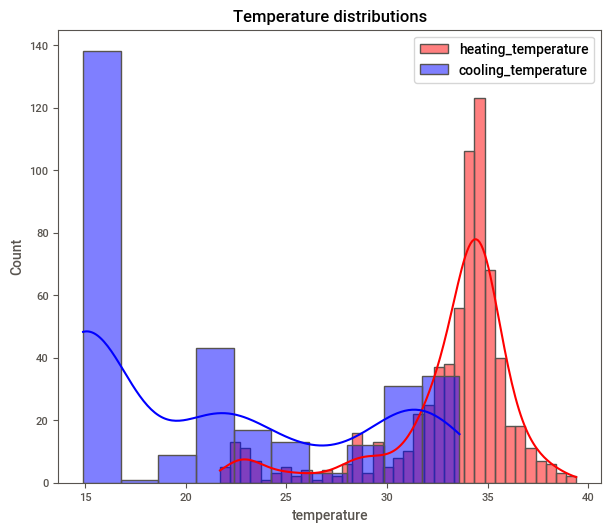

In [3]:
plt.subplots(figsize=(7,6), dpi=100)
sns.histplot( df.loc[df.property_name=='heating_temperature','temperature'] , color="red", label="heating_temperature", kde=True)
sns.histplot( df.loc[df.property_name=='cooling_temperature','temperature'] , color="blue", label="cooling_temperature", kde=True)
plt.title('Temperature distributions')
plt.legend()

In the following we change the table format to get the time axis (df index) w/o duplicates and
plot the time series (color indicates property_name). The data points exibit an recurring pattern
for the heating and cooling phases on certain days.

In [4]:
dft=df.loc[df.property_name=='heating_temperature'][['temperature']].rename(columns={'temperature':'heating_temperature'}).merge(
    df.loc[df.property_name=='cooling_temperature'][['temperature']].rename(columns={'temperature':'cooling_temperature'}),how='outer',left_index=True,right_index=True)

line_colors = ["rgba(0, 0, 255,30)","rgba(255, 0, 255,30)"]

fig = px.scatter(dft.reset_index(), x='datetime', y=['cooling_temperature','heating_temperature'], title='Time Series',color_discrete_sequence=line_colors)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

## 3. Daily, Hourly Seasonalities and Time Differences
To check if there are hourly, weekly or even monthly seasonalities and trends we inspect the distributions below and
also give a cumulative distribution of time difference between consecutive data points.

<AxesSubplot:xlabel='hour', ylabel='temperature'>

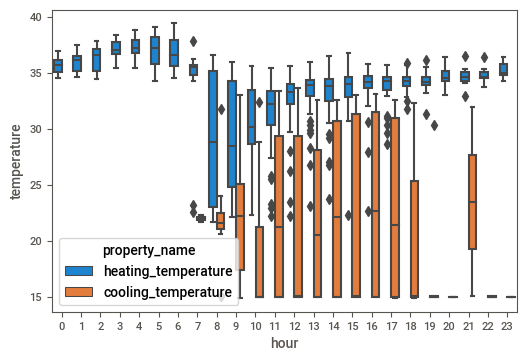

In [5]:
data=df
data['hour']=data.index.hour
sns.boxplot(data=data,x="hour",y='temperature',hue="property_name")

<AxesSubplot:xlabel='weekday', ylabel='temperature'>

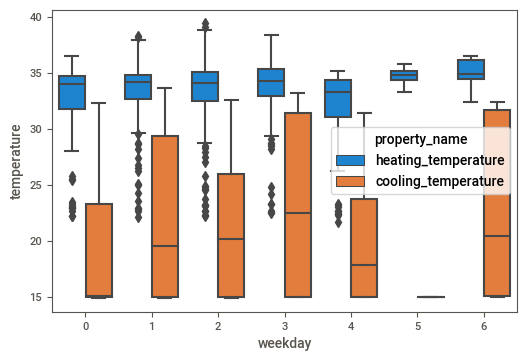

In [6]:
data=df
data['weekday']=data.index.weekday
sns.boxplot(data=data, x="weekday", y="temperature", hue="property_name")

          datetime
count   715.000000
mean      9.587537
std      76.944205
min       0.063056
25%       1.000278
50%       1.000556
75%       1.000556
max    1702.840833


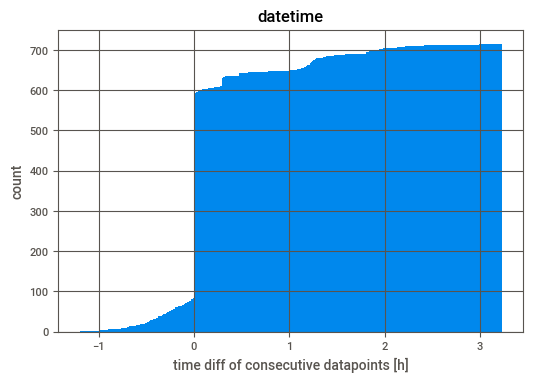

In [7]:
dt=pd.DataFrame((dft.index[1:]-dft.index[0:-1]).total_seconds()/60./60.).apply(np.log10).hist(cumulative=True,bins=1000)
plt.xlabel('time diff of consecutive datapoints [h]')
plt.ylabel('count')
print(pd.DataFrame((dft.index[1:]-dft.index[0:-1]).total_seconds()/60./60.).describe())

The above visualizations give us enough reason to believe that recurring temperatures are monitored and that meaningful
modeling and analysis can be made in segments. In order to classify segments as independent curves
we continue to split up the data set and model each segment separatly with a Spline and piecewise
linear interpolation enabling us to proceed with an equidistant dataset and further analysis or leaving the
models as the final product of this challenge.

## 4. Hierarchical Clustering for Segmentation
There are several ways to find the right cut-off distance but since we do not know much about the data set we
go ahead and employ handwavingly two commonly used methods: (a) the "elbow" method and (b) the dendogram inspection.
First we check the number of remaining clusters versus different threshold distances.
We come to the conclusion that the biggest drop in numbers of clusters according to method (a) occurs around 4000 and 7500 seconds.
Using the dendrogram (b) we also find these gaps, though we would lose some clusters at slightly higher distance.
So we reconcider and go with a threshold at 8000 seconds.

In [8]:
thresh_arr=[]
nclusters_arr=[]
for ithresh in range(1,2000):
    thresh = 500*ithresh
    thresh_arr.append(thresh)
    df_cl_t=np.vstack([df.index.astype(np.int64) // 10**9,df.temperature]).T
    df_cl=np.vstack([df.index.astype(np.int64) // 10**9]).T
    clusters = hcluster.fclusterdata(df_cl, thresh, criterion="distance")
    nclusters_arr.append(len(set(clusters)))

line_colors = ["rgba(0, 0, 255,30)","rgba(255, 0, 255,30)"]

fig = px.scatter(pd.DataFrame(np.vstack([thresh_arr,nclusters_arr]).T,columns=['Threshold','N_Clusters']), x='Threshold', y='N_Clusters', title='Time Series',color_discrete_sequence=line_colors)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

(0.0, 10000.0)

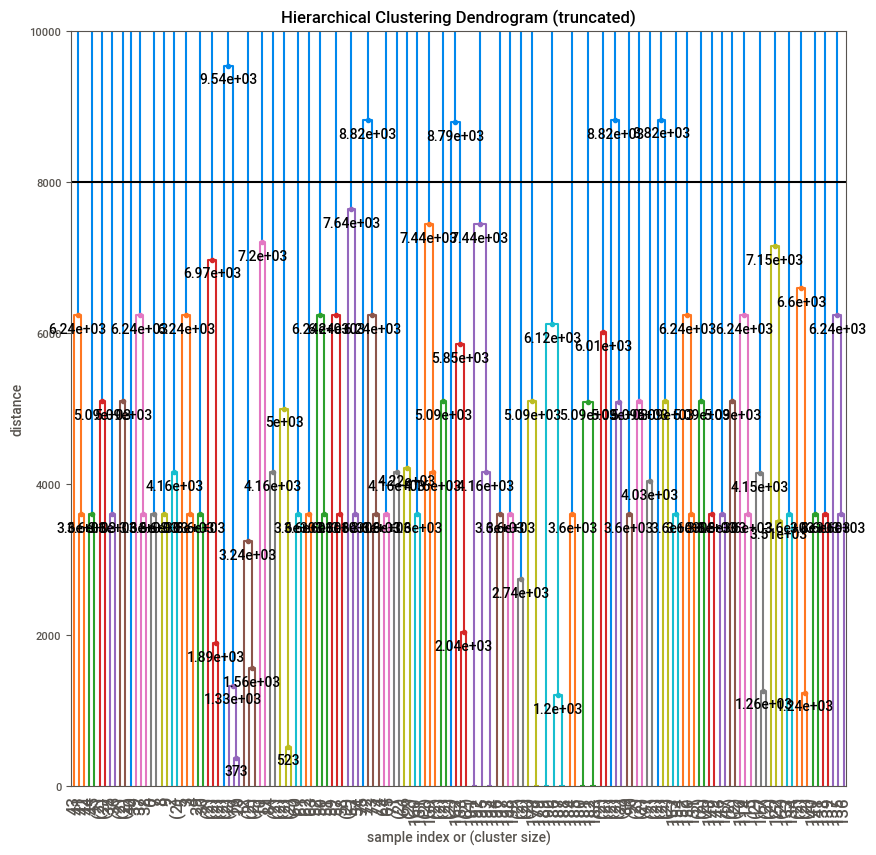

In [12]:
from scipy.cluster.hierarchy import dendrogram, linkage
def fancy_dendrogram(*args, **kwargs):
    """
    This is a wrapper function for the scipy.cluster.hierarchy function dendogram
    """
    ylim=kwargs['ylim']
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)
    del kwargs['ylim']
    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            yy = d[1]
            if (yy > annotate_above) & (yy < ylim):
                plt.plot(x, yy, 'o', c=c)
                plt.annotate("%.3g" % yy, (x, yy), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

df_cl=np.vstack([df.index.astype(np.int64) // 10**9]).T
X = linkage(df_cl[0:200], 'ward')
plt.figure(figsize=(10,10))
fancy_dendrogram(
    X,
    truncate_mode='lastp',
    p=150,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=40,
    max_d=8000,
    ylim=10000
)
plt.ylim(0,10000)

Since we are able to segment the time series into samples that represent what we can call the heating phase, it
seems now prudent to find convenient representations of the phase and to model the behaviour.
From here on we can also come up with trained models as well as interpolations. How to proceed depends on our understanding of
the curves. If we want to address temperatures at times for which there is no measurement available,
we can proceed with the following. If we were to come up with a forecast on what will be the next temperature value based
on observations, we may now proceed with less basic models, such as ETS and progress toward supervised learning methods such as LSTM.
Employing this here will be beyond the scope of the challenge. Hence, we go ahead and prepare the output:
the interpolated heating and cooling phase curves. But let's have one last look at the clustered or segmented time series:

In [13]:
import scipy.cluster.hierarchy as hcluster
import plotly.express as px

thresh = 8000
df_cl_t=np.vstack([df.index.astype(np.int64) // 10**9,df.temperature]).T
df_cl=np.vstack([df.index.astype(np.int64) // 10**9]).T
clusters = hcluster.fclusterdata(df_cl, thresh, criterion="distance")
line_colors = ["rgba(0, 0, 255,30)","rgba(255, 0, 255,30)"]

data = df
data['cluster']=clusters
fig = px.scatter(data, x='datetime', y='temperature',color='cluster', title='Time Series')
fig.update_xaxes(rangeslider_visible=True)
fig.show()


## 5. Modeling of Time Series Segments
The output will be placed in the notebooks folder. Note that as we use a smoothed cubic spline we have to carefully assess
the overshooting or switch to Catmull-Rom Splines.

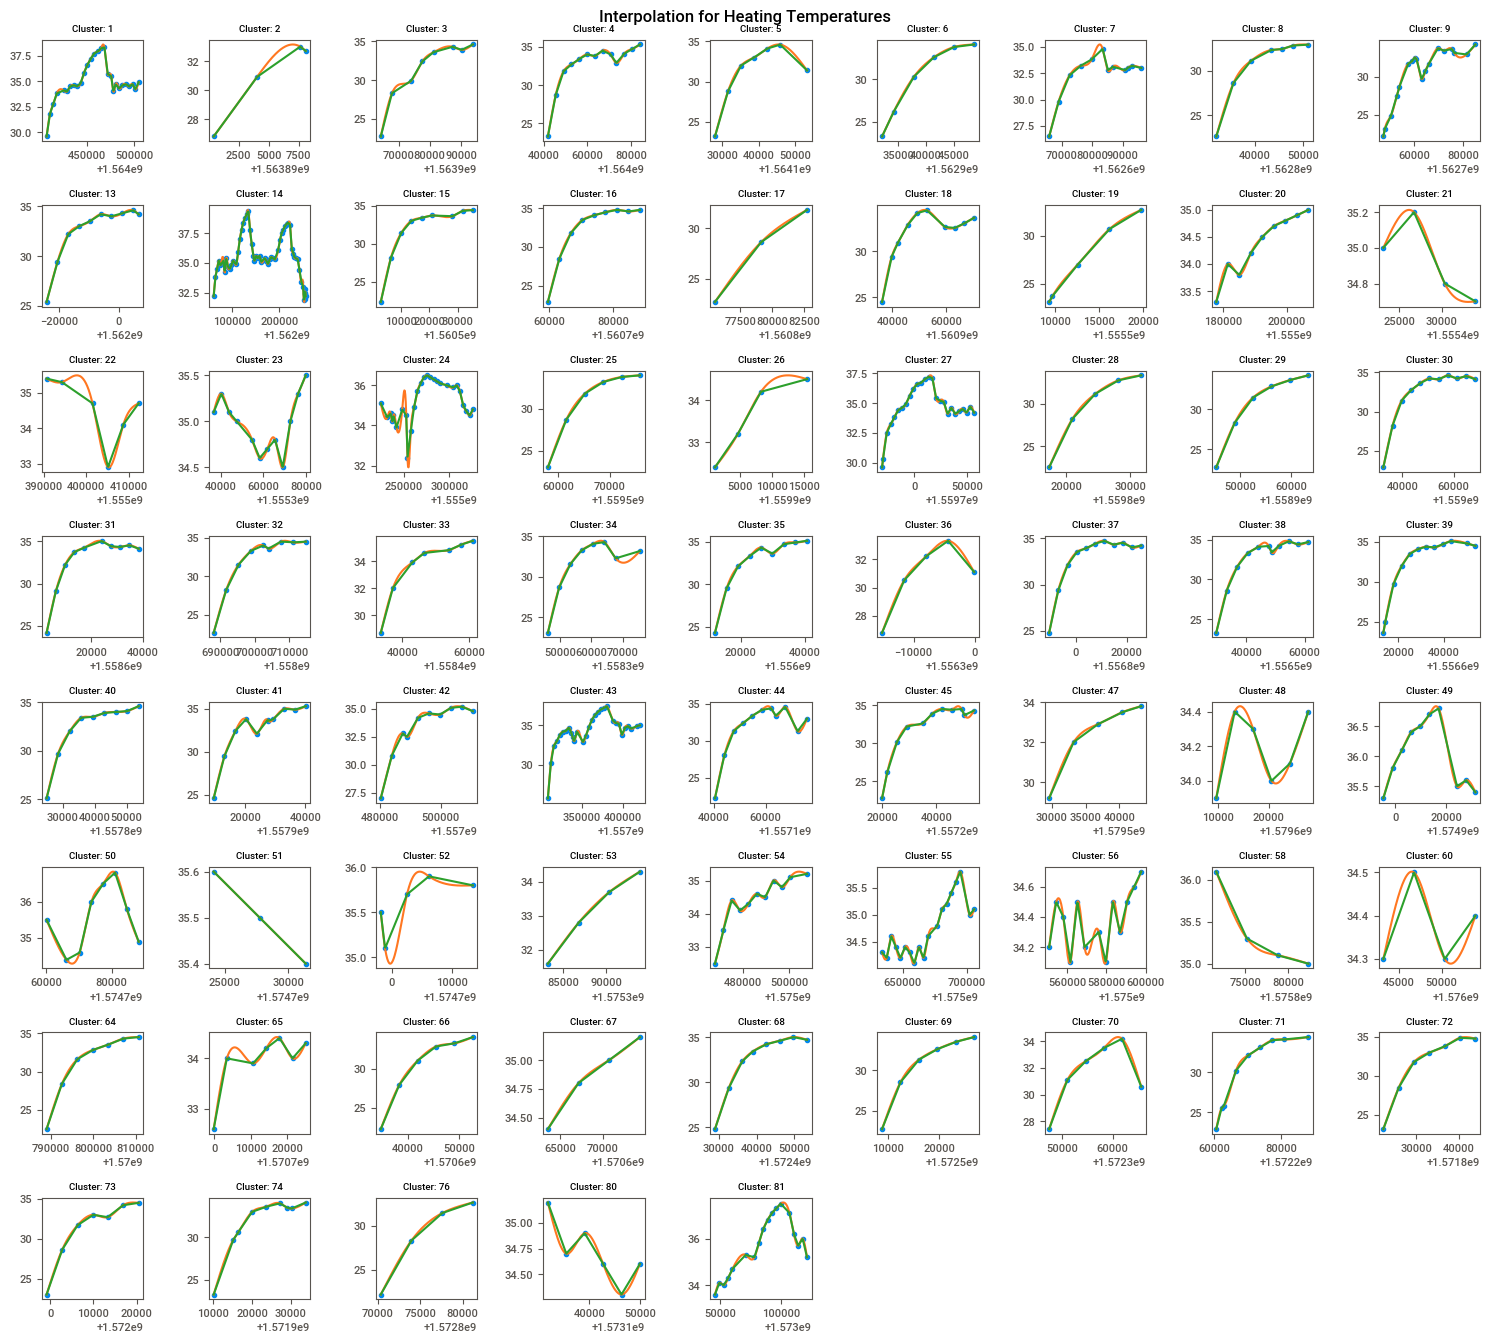

In [14]:
from csaps import csaps
from scipy import interpolate
n=9
fig, axs = plt.subplots(n, n, figsize=(15,15))

cnt=-1
for c in set(clusters):
    cnt+=1
    i=cnt%n
    j=int(cnt/n)
    if cnt<n*n:
        dfs=df[(df['cluster']==c) & (df.property_name=='heating_temperature')] #.reset_index(drop=True).plot(y='temperature')

        x=dfs.index.astype(np.int64) // 10**9
        y=dfs.temperature
        if len(x) >2:
            sp = csaps(x, y, smooth=0.1)
            xs = np.linspace(x[0], x[-1], 200)
            ys = sp(xs)

            fl = interpolate.interp1d(x, y)
            yl = fl(xs)
            axs[j, i].plot(x, y,'o')
            axs[j, i].plot(xs, ys,'-')
            axs[j, i].plot(xs, yl,'-')
            axs[j, i].set_title('Cluster: '+str(c), fontsize=7)
        else:
            cnt-=1 #plt.plot(x, y, 'o', xs, ys, '-')
for cc in range(cnt+1,n*n):
    i=cc%n
    j=int(cc/n)
    fig.delaxes(axs[j,i])

fig.suptitle('Interpolation for Heating Temperatures')
plt.tight_layout()

plt.savefig('heating_clusters.png',dpi=600)

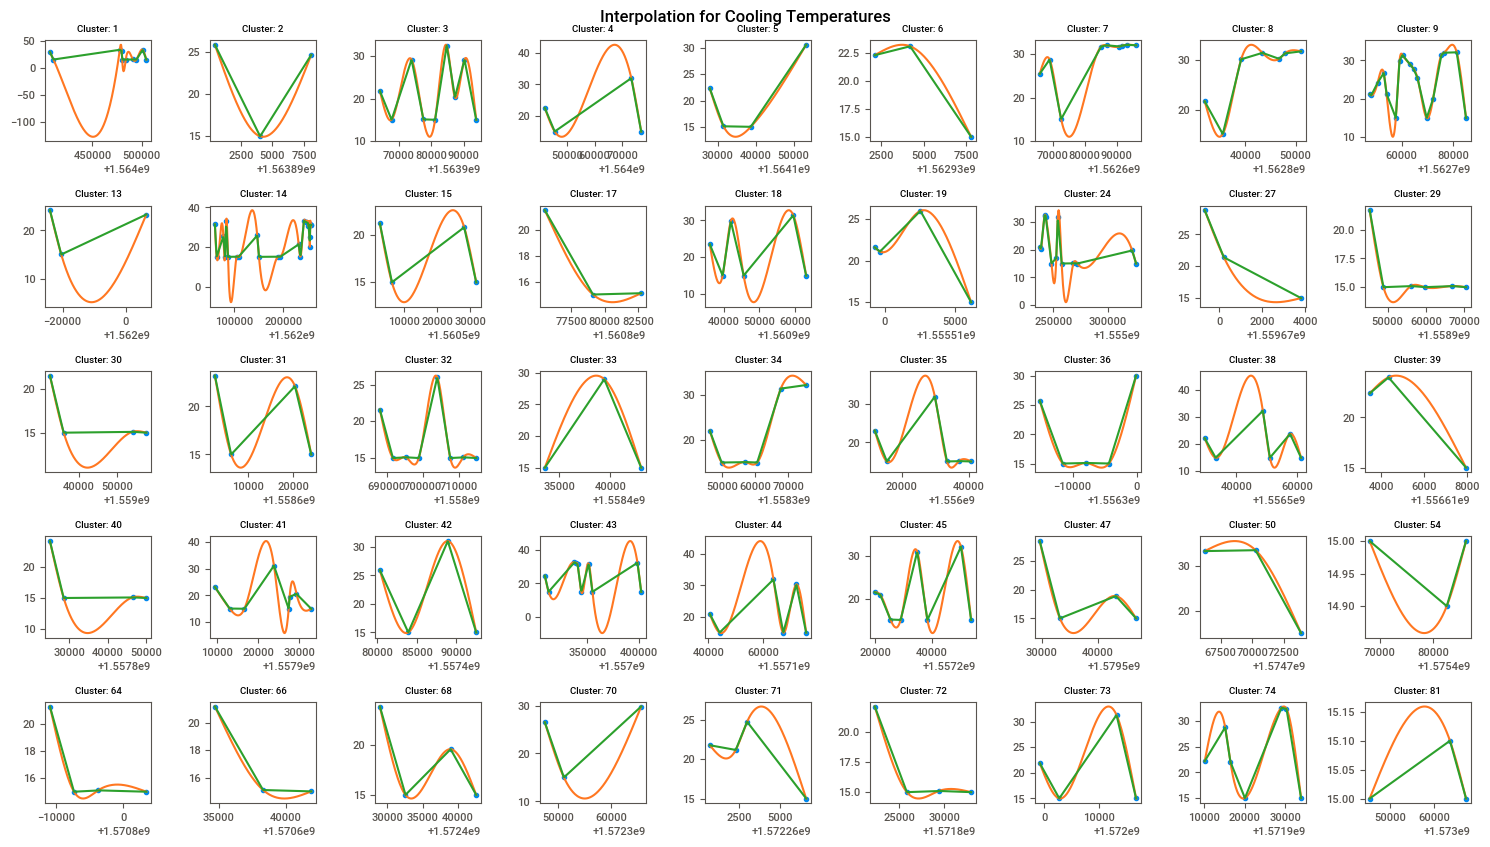

In [15]:
n=9
fig, axs = plt.subplots(n, n, figsize=(15,15))

cnt=-1
for c in set(clusters):
    cnt+=1
    i=cnt%n
    j=int(cnt/n)
    if cnt<n*n:
        dfs=df[(df['cluster']==c) & (df.property_name=='cooling_temperature')] #.reset_index(drop=True).plot(y='temperature')

        x=dfs.index.astype(np.int64) // 10**9
        y=dfs.temperature
        if len(x) >2:
            sp = csaps(x, y, smooth=0.1)
            xs = np.linspace(x[0], x[-1], 200)
            ys = sp(xs)

            fl = interpolate.interp1d(x, y)
            yl = fl(xs)
            axs[j, i].plot(x, y,'o')
            axs[j, i].plot(xs, ys,'-')
            axs[j, i].plot(xs, yl,'-')
            axs[j, i].set_title('Cluster: '+str(c), fontsize=7)
        else:
            cnt-=1 #plt.plot(x, y, 'o', xs, ys, '-')
for cc in range(cnt+1,n*n):
    i=cc%n
    j=int(cc/n)
    fig.delaxes(axs[j,i])
fig.suptitle('Interpolation for Cooling Temperatures')
plt.tight_layout()

plt.savefig('cooling_clusters.png',dpi=600)

## 6. Final Remarks
Lastly I'd like to spend a moment on general Time Series handling. If we were to fill the NaNs in a
frequency fixed time series (see table below), we would go on and do a forward / backward or interpolation resampling.
Assuming that aggregating days (using max. temperature) will suffice to get a dataframe
on which we can address the point, we proceed and use the usual resampling tools.
It should be noted that doing this goes against better judgement, as the measurement periods are small compared to
9 months of the data set and the off-times, the maximum of which is >2 months.
We show the aggregated time series and the interpolated one filling the voids.
Latter data product can be used for an attempt on seasonality decomposition.
The decomposition is done w.r.t. a 7-day and 30-day seasonality component.
In the max. heat temperature curve the components are of order 1-2% of the observed level and negligible w.r.t. to the residuals.

In [16]:
# checking the max temperatures per day and data points per day
dft['date']=dft.index.date
data=dft.groupby(['date']).agg({'heating_temperature': ['max','count']})
data.columns= ['_'.join(col).strip() for col in data.columns.values]
data.reset_index(inplace=True)
data.index = pd.to_datetime(data.date)
data=data.asfreq('d')
data

date  heating_temperature_max  heating_temperature_count
date                                                                      
2019-04-13  2019-04-13                     34.8                        7.0
2019-04-14  2019-04-14                     36.5                       19.0
2019-04-15  2019-04-15                     36.2                       20.0
2019-04-16  2019-04-16                     35.5                       12.0
2019-04-17  2019-04-17                     32.7                        5.0
...                ...                      ...                        ...
2020-01-20  2020-01-20                     33.8                        5.0
2020-01-21  2020-01-21                     34.4                        6.0
2020-01-22         NaN                      NaN                        NaN
2020-01-23         NaN                      NaN                        NaN
2020-01-24  2020-01-24                     21.7                        1.0

[287 rows x 3 columns]

In [17]:
import plotly.express as px
fig = px.scatter(data, x='date', y='heating_temperature_max', color='heating_temperature_count', title='Time Series',color_discrete_sequence=line_colors)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [18]:
data2=data.resample('1D').mean().interpolate()
data2['date']=data2.index
import plotly.express as px
fig = px.scatter(data2, x='date', y='heating_temperature_max', color='heating_temperature_count', title='Time Series with interpolated values (not recommendable)',color_discrete_sequence=line_colors)
fig.update_xaxes(rangeslider_visible=True)
fig.show()

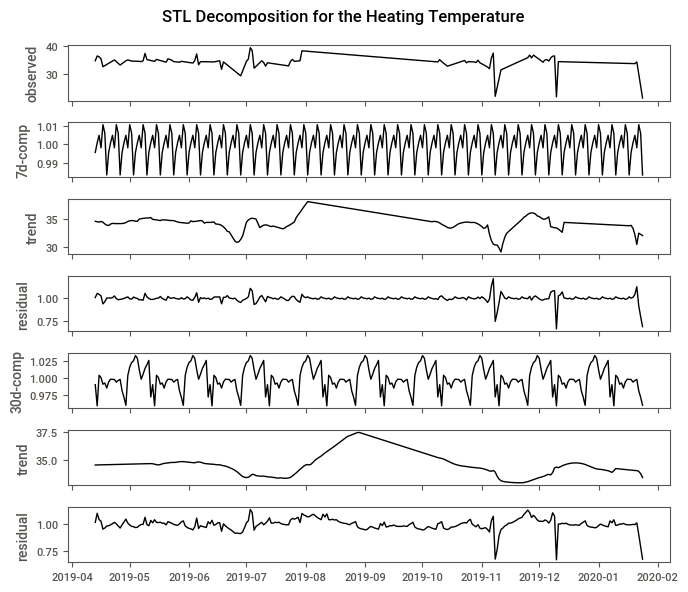

In [21]:
result_mul = seasonal_decompose(data2['heating_temperature_max'], model='multiplicative', period=7,extrapolate_trend='freq')
fig, ax=plt.subplots(7,1,figsize=(7,6),sharex=True)
plt.suptitle('STL Decomposition for the Heating Temperature ')
ax[0].plot(result_mul.observed,'k-',linewidth=1)
ax[0].set(ylabel='observed')
ax[1].plot(result_mul.seasonal,'k-',linewidth=1)
ax[1].set(ylabel='7d-comp')
ax[2].plot(result_mul.trend,'k-',linewidth=1)
ax[2].set(ylabel='trend')
ax[3].plot(result_mul.resid,'k-',linewidth=1)
ax[3].set(ylabel='residual')
result_mul2 = seasonal_decompose(data2['heating_temperature_max'], model='multiplicative', period=30,extrapolate_trend='freq',two_sided=False) #two_sided=False
ax[4].plot(result_mul2.seasonal,'k-',linewidth=1)
ax[4].set(ylabel='30d-comp')
ax[5].plot(result_mul2.trend,'k-',linewidth=1)
ax[5].set(ylabel='trend')
ax[6].plot(result_mul2.resid,'k-',linewidth=1)
ax[6].set(ylabel='residual')
plt.tight_layout()


Oh well, times up. I hope you enjoyed this notebook.

